## Setup

In [128]:
# ---------------------------------------------------
# 📦 LIBRERÍAS
# ---------------------------------------------------
from google.cloud import bigquery
from io import BytesIO
from PIL import Image
from google.api_core import exceptions
from googleapiclient.discovery import build

from googleapiclient.http import MediaFileUpload, MediaIoBaseUpload
from google import genai
from google.genai.types import Part, GenerateContentConfig
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google import auth
from pathlib import Path
from google.genai import types
# ---------------------------------------------------

# 📦 Parámetros de configuración

PROJECT = "lmes-aiforlmes-d-f86"
LOCATION = "europe-west1"
AI_MODEL_NAME = "gemini-2.5-flash-image"
# AI_MODEL_NAME = "gemini-3-pro-image-preview"
MODEL_SELECT_IMAGE = "gemini-2.5-flash"
FOLDER_IMAGES = "./imagenes_dameo_cotas/"
DRIVE_FOLDER_NAME = "Pruebas_cotas"

reference = 70842912
model_name = "gemini-2.5-flash-image"

genai_client = genai.Client(vertexai=True, project=PROJECT, location="europe-west1")

client = bigquery.Client(project=PROJECT, location="EU")

# Usa las credenciales configuradas con gcloud auth application-default login
# Los scopes ya están incluidos en las credenciales ADC
creds, _ = auth.default()
drive_service = build('drive', 'v3', credentials=creds)

## Prompts, funciones auxiliares,  y queries

### Prompts

In [129]:
PICTOGRAM_PROMPT = """
You are a technical illustrator specialized in creating product dimension diagrams.

TASK: Generate a clean, black and white line art illustration of the product from the reference image.

STYLE REQUIREMENTS:
- **Line Art Only**: Pure black lines on white background
- **No Shading**: Absolutely no fills, gradients, or shadows
- **High Detail**: Capture all visible edges, corners, and surface details
- **Perspective**: Maintain the exact viewing angle from the reference image
- **Clean Lines**: Crisp, professional technical drawing quality

CONTENT RULES:
- Product ONLY: No background, no text, no dimensions, no labels
- Complete Visibility: Entire product must be visible within the canvas
- Margins: Leave 15-20% white space around the product for future dimension lines
- Background: Pure white (#FFFFFF)

OUTPUT SPECIFICATIONS:
- Format: High-resolution PNG
- Style: Similar to architectural blueprints or CAD line drawings
- No annotations of any kind

This illustration will be used as a base for adding technical dimension lines in the next step.
"""

SELECT_BETTER_IMAGE_PROMPT = """
### TASK: SELECT THE BEST IMAGE FOR TECHNICAL DIMENSIONING ###

**ROLE:** You are an expert Technical Image Analyst and CAD Draftsman. Your goal is to identify the single most suitable image from a provided set for the application of technical dimension lines (extension lines, dimension lines, and leaders) based on the available measurement data.

---

### 1. SELECTION HIERARCHY & STRICT 3D VALIDATION

**SCENARIO A: Three Dimensions Provided (e.g., Length, Width, Height)**
* **Target:** 3D Perspective (Isometric, Oblique, or 3/4 View).
* **STRICT 3D CRITERIA:** Only select a 3D image if it passes the "Three-Plane Visibility Test":
    1. X, Y, and Z Visibility: The Length, Width, and Depth planes must all be clearly visible and distinguishable.
    2. Vertex Clarity: The corners (vertices) where dimension lines would start and end must be sharp and not obscured by shadows, glare, or the product's own geometry (no self-occlusion).
    3. Geometric Legibility: The perspective must not be so extreme (e.g., "fish-eye" or extreme low angle) that a straight dimension line would look technically incorrect or overlap the product body in a confusing way.
* **Fallback:** If no 3D image satisfies ALL criteria above, you MUST revert to the best 2D Orthogonal view.

**SCENARIO B: Two or Fewer Dimensions Provided**
* **Target:** 2D Orthogonal View (Front, Side, or Top).
* **Logic:** Even if 3D images exist, you MUST prioritize a "flat" 2D view. This ensures the 2D data matches the 2D visual representation. Set "can_add_3d_dimensions" to false.

---

### 2. TECHNICAL DRAWING VIABILITY (The "Draftsman Test")
Regardless of the dimension count, an image is only "Best" if a draftsman can actually work on it:
1. The "Offset" Rule (Padding): The product must not touch the edges of the frame. There must be at least 15% whitespace (padding) around the product to accommodate dimension strings without crossing the image border.
2. Edge Contrast: There must be high contrast between the product edge and the background to allow for precise placement of extension lines.
3. No Obstructions: Zero tolerance for hands, tools, shipping labels, or packaging that covers a measurable edge.

---

### 3. MANDATORY DECISION LOGIC

1. COUNT the dimensions provided in the user data.
2. EVALUATE 3D VIABILITY: If 3 dimensions are provided, inspect 3D images for the "Three-Plane Visibility Test." 
    * Can I see the top, front, and side clearly?
    * Are the corners clear enough to "snap" a line to?
    * Is there enough room in the margins for the lines?
3. IF 3D CRITERIA FAIL: Select the best 2D view and set "can_add_3d_dimensions": false.
4. SELECT the final index based on these constraints.

---
### 4. OUTPUT FORMAT (JSON ONLY)
Respond ONLY with valid JSON in this exact format:

{
    "selected_index": <integer from 1 to N>,
    "can_add_3d_dimensions": <true or false>,
    "confidence_score": <float between 0.0 and 1.0>,
    "quality_score": <integer from 1 to 10>
}
"""

### Queries

In [130]:
# sql_opus_dimensiones = f"""
# SELECT productReferenceBu, t.type, media_item.type, media_item.url, media_item.label
# FROM `opus-prod-lmes.lmes_opus_product.adeo_prod_europe_west1_APP_OPUS_CONTENT_LM_ES_P1_C3_PRODUCT_CORE_MEDIA_V1_com_adeo_CatalogsBroadcast_ProductCoreMediaValue` as t,
# UNNEST(media) AS media_item
# WHERE TIMESTAMP_TRUNC(_PARTITIONTIME, DAY) = TIMESTAMP("2025-09-19") and media_item.type = "photo"
# """
# opus_dimensiones = client.query(sql_opus_dimensiones).to_dataframe()
# opus_dimensiones
# quiza esta consulta esta mal saca muchos datos repetidos
sql_dimension_reference = f"""
SELECT 
    productReferenceBu, att.code as code_char, att.name as name_char, d.value.double as value_char
FROM `opus-prod-lmes.lmes_opus_product.adeo_prod_europe_west1_APP_OPUS_CONTENT_LM_ES_P1_C3_PRODUCT_CORE_ATTRIBUTE_V1_com_adeo_CatalogsBroadcast_ProductCoreAttributeValue`,
    UNNEST(attributes) AS att,
    UNNEST(att.data) AS d
WHERE 
  att.code IN(
    "00053", # anchura en cm
    "00256", # longitud en cm
    "13313"  # altura  del plato sin pata cm
    ) 
  and productReferenceBu = cast({reference} as STRING)
"""

sql_mod_from_reference = f"""
-- Name and code of the model
with metadata_mod as (
    Select
        productModelIdentifier as cod_mod, productModelName as name_mod
    From
        `dfdp-pdp-prod-master-dat-prod.collected_product_metadata.productModel`
    Where
        languageAlpha2Code = "ES"
)
SELECT
     t.cod_mod, m_model.name_mod
FROM 
    `dfdp-teradata6y.ProductFeaturesLmes.TDGEN_PVTPRD_ART` as t
inner join metadata_mod as m_model
 on concat("MOD_", t.cod_mod) = m_model.cod_mod
where
    num_art = {reference}
 """

sql_get_images_dameo = f"""
SELECT
    productId, mediaLinkUrl
FROM 
    `dfdp-dameo-data.productMediaLink.product_media_link` 
where 
    bu = 2 and productId = {reference} and mediatype = "IMG" and mediaCategory = "P"
"""

### Funciones auxiliares

In [ ]:
def get_better_image_to_add_pattern(image_parts, number_dimensions):
    """GDevuelve la imagen para generar cotas con el mejor encuadre"""
    full_prompt =  "VERY IMPORTANT: There are " + str(number_dimensions) + " dimension measurements to consider.\n" + SELECT_BETTER_IMAGE_PROMPT

    # Preparar contenido para la API
    contents = [Part.from_text(text=full_prompt)] + image_parts
    
    # print(full_prompt)
    try:
        # Generar respuesta
        response = genai_client.models.generate_content(
            model=MODEL_SELECT_IMAGE,
            contents=contents,
            config=GenerateContentConfig(
                temperature=0,  # Baja temperatura para respuestas más deterministas
                response_mime_type="application/json"
            )
        )
        
        result = json.loads(response.text)
        
        # Convertir a 0-indexed
        result['selected_index'] = result.get('selected_index', 1) - 1
        
        # Mostrar información detallada
        print("=" * 80)
        print(f"✅ IMAGEN SELECCIONADA: {result['selected_index'] + 1}/{len(image_parts)//2}")
        print("=" * 80)
        print(f"🎯 ¿Puede añadir cotas 3D?: {'SÍ' if result.get('can_add_3d_dimensions') else 'NO'}")
        print(f"🔍 Confianza: {result.get('confidence_score', 'N/A')}")
        print(f"⭐ Puntuación de calidad: {result.get('quality_score', 'N/A')}/10")


        if result.get('can_add_3d_dimensions'):
            visible_dims = {'length': True, 'width': True, 'thickness': True}
        else:
            # Vista 2D: solo largo y ancho visibles, grosor en cuadro
            visible_dims = {'length': True, 'width': True, 'thickness': False}

        print(f"\n📐 Dimensiones detectadas como visibles:")
        print(f"   • Longitud (lado largo): {'✓' if visible_dims.get('length') else '✗'}")
        print(f"   • Anchura (lado corto): {'✓' if visible_dims.get('width') else '✗'}")
        print(f"   • Grosor/Altura (espesor): {'✓' if visible_dims.get('thickness') else '✗'}")
                
        if result.get('alternative_suggestions'):
            print(f"\n💡 Sugerencias alternativas:")
            print(f"   {result.get('alternative_suggestions')}")
        
        print("=" * 80)
        
        return result
        
    except Exception as e:
        print(f"⚠️ Error al seleccionar imagen: {e}")
        raise

def get_pictogram_from_image(image: Image.Image) -> Image.Image:
    """Genera un pictograma lineal a partir de una imagen de producto.
    
    Args:
        image: Imagen PIL del producto
    
    Returns:
        Respuesta de la API con la imagen generada
    """
    
    full_prompt = PICTOGRAM_PROMPT
    
    # Convertir la imagen PIL a bytes en formato PNG
    img_byte_arr = BytesIO()
    image.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()  # Obtener los bytes
    
    contents = [
        Part.from_text(text=full_prompt), 
        Part.from_bytes(data=img_byte_arr, mime_type="image/png")
    ]
    
    try:
        response = genai_client.models.generate_content(
            model=AI_MODEL_NAME,
            contents=contents,
            config=GenerateContentConfig(
                temperature=0,  # Determinístico para resultados consistentes
            )
        )
        print("Picto generado correctamente")
        return response
    
    except Exception as e:
        print(f"⚠️ Error al generar pictograma: {e}")
        raise

def create_technical_prompt(visible_dims):
    """
    Genera el prompt para añadir cotas técnicas según las especificaciones de Leroy Merlin.
    
    Args:
        visible_dims: Diccionario con las dimensiones visibles y sus valores formateados
                     Keys: 'length' (largo), 'width' (ancho), 'thickness' (grosor/altura)
    
    Returns:
        str: Prompt completo para la generación de cotas
    """
    dim_count = len(visible_dims)
    has_thickness_visible = visible_dims.get('thickness') is not None
    
    # Determinar si necesitamos el cuadro de grosor
    needs_thickness_box = (
        len([v for v in visible_dims.values() if v.get('value')]) == 3 
        and not has_thickness_visible
    )
    
    # ============================================================================
    # REGLA FUNDAMENTAL
    # ============================================================================
    prompt_text = f"""
CRITICAL RULE: Add EXACTLY {dim_count} dimension lines. ONE line per dimension. NO duplicates.

TASK: Add technical dimension annotations to this shower tray illustration.

CANVAS: 2000px × 2000px, 72 DPI, sRGB, white background (#FFFFFF)
PRODUCT: Centered, occupying 85% of canvas, three-quarter isometric view

"""

    # ============================================================================
    # ESPECIFICACIONES TÉCNICAS
    # ============================================================================
    prompt_text += """
DIMENSION LINE SPECS:

Main Lines (Length & Width):
- Stroke: 4px black (#000000), no fill
- Arrows: Solid black triangles, 20px wide × 20px long, 1px stroke, 0% concavity
- Text: Leroy Merlin Sans Semibold 50pt, black, HORIZONTAL only
- Decimal separator: COMMA (,) - Example: "90,5 cm" NOT "90.5 cm"

Thickness Line (if visible in main view):
- Stroke: 2px black (#000000), no fill  
- Arrows: Solid black triangles, 10px wide × 10px long, 1px stroke, 0% concavity
- Text: Same as above (Leroy Merlin Sans Semibold 50pt, horizontal, comma separator)

"""

    # ============================================================================
    # DIMENSIONES A AÑADIR
    # ============================================================================
    prompt_text += f"ADD THESE {dim_count} DIMENSIONS (ONE LINE EACH):\n\n"
    
    if has_thickness_visible:
        # CASO 3D: 3 líneas en la ilustración principal
        placement_instructions = {
            "length": {
                "desc": "LENGTH (longer side)",
                "where": "BELOW the tray, parallel to bottom edge, 80-120px away",
                "text": "Centered above the line, horizontal",
                "specs": "4px stroke, 20px arrows"
            },
            "width": {
                "desc": "WIDTH (shorter side)", 
                "where": "RIGHT side, parallel to receding edge in perspective, 80-120px away",
                "text": "Centered above the line, horizontal",
                "specs": "4px stroke, 20px arrows"
            },
            "thickness": {
                "desc": "THICKNESS (vertical edge)",
                "where": "LEFT side, parallel to vertical edge, 60-80px away",
                "text": "Centered to the right of the line, horizontal",
                "specs": "2px stroke, 10px arrows"
            }
        }
    else:
        # CASO 2D: 2 líneas en la ilustración + 1 en cuadro
        placement_instructions = {
            "length": {
                "desc": "LENGTH (longer side)",
                "where": "BELOW the tray, parallel to bottom edge, 80-120px away",
                "text": "Centered above the line, horizontal",
                "specs": "4px stroke, 20px arrows"
            },
            "width": {
                "desc": "WIDTH (shorter side)", 
                "where": "RIGHT side, parallel to perspective edge, 80-120px away",
                "text": "Centered above the line, horizontal",
                "specs": "4px stroke, 20px arrows"
            }
        }
    
    counter = 1
    for dim_key, dim_info in visible_dims.items():
        if dim_key in placement_instructions:
            instr = placement_instructions[dim_key]
            formatted_val = dim_info['formatted']
            
            prompt_text += f"""
{counter}. {instr['desc']}: {formatted_val}
   Position: {instr['where']}
   Line specs: {instr['specs']}
   Text: {instr['text']}

"""
            counter += 1

    # ============================================================================
    # CUADRO DE GROSOR (SOLO si thickness NO es visible)
    # ============================================================================
    if needs_thickness_box:
        thickness_value = None
        for dim_info in visible_dims.values():
            if 'altura' in dim_info.get('name', '').lower():
                thickness_value = dim_info.get('formatted', '2 cm')
                break
        
        prompt_text += f"""
THICKNESS DETAIL BOX (MANDATORY):
- Size: 442px × 442px square
- Position: Center at (300px, 1740px)
- Stroke: 4px black, no fill
- Content: Cross-section diagram + ONE vertical dimension line showing {thickness_value}
- Use 2px stroke, 10px arrows for this line

"""
    else:
        prompt_text += """
NO THICKNESS BOX NEEDED - All 3 dimensions are visible in the main view.

"""

    # ============================================================================
    # RESTRICCIONES CRÍTICAS
    # ============================================================================
    prompt_text += f"""
CRITICAL CONSTRAINTS:

✓ Add EXACTLY {dim_count} dimension lines (count them!)
✓ Each dimension gets ONE line only - NO duplicates
✓ All dimension lines OUTSIDE product outline (min 60px clearance)
✓ Text always HORIZONTAL, never rotated
✓ Use COMMA (,) for decimals, never period (.)
✓ Font: Leroy Merlin Sans Semibold 50pt only
✓ Color: Pure black (#000000) only
✓ Maintain 300px margins on all canvas sides
✓ Thickness box: {'INCLUDE at (300px, 1740px)' if needs_thickness_box else 'DO NOT ADD'}

✗ FORBIDDEN:
  - Adding extra dimension lines
  - Duplicating any dimension
  - Rotating text vertically
  - Using periods (.) as decimal separators
  - Modifying the product illustration

VERIFICATION BEFORE FINALIZING:
□ Counted dimension lines = {dim_count}?
□ All text uses comma (,) separator?
□ All text is horizontal (0° rotation)?
□ Correct line weights (4px main, 2px thickness)?
□ Thickness box {'present' if needs_thickness_box else 'absent'}?
"""

    return prompt_text


def get_dimensions_added_from_pictogram(
    dimensiones: dict, 
    image: Image.Image, 
    visible_dimensions: dict
) -> Image.Image:
    """
    Añade cotas técnicas a una imagen basándose en las dimensiones visibles.
    
    Args:
        dimensiones: Diccionario con todas las dimensiones disponibles
            Ejemplo: {'Altura (en cm)': 137.8, 'Anchura (en cm)': 105, 'Profundidad (en cm)': 48}
        image: Imagen PIL del producto
        visible_dimensions: Diccionario indicando qué dimensiones son visibles
            Ejemplo: {"width": True, "height": True, "depth": False}
    
    Returns:
        Respuesta de la API con la imagen generada
    """
    
    # Mapeo de dimensiones visibles a nombres de características (normalizado)
    # Mapeo ACTUALIZADO: 
    # - "length" = Longitud (el lado más largo del plato)
    # - "width" = Anchura (el lado más corto del plato)
    # - "thickness" = Altura (el grosor/altura del plato, típicamente 2cm)
    dimension_mapping = {
        "length": ["Longitud"],  # Lado largo
        "width": ["Anchura"],      # Lado corto
        "thickness": ["Altura"]  # Grosor vertical
    }
    
    # Filtrar solo las dimensiones visibles
    visible_dims = {}
    
    for dim_key, is_visible in visible_dimensions.items():
        if is_visible:
            # Buscar el valor correspondiente en el diccionario de dimensiones
            for possible_name in dimension_mapping.get(dim_key, []):
                # Buscar coincidencia parcial en las claves del diccionario
                for dimension_name, dimension_value in dimensiones.items():
                    if possible_name.lower() in dimension_name.lower():
                        # Formatear el valor
                        if isinstance(dimension_value, float):
                            # Mantener decimales si existen, sino mostrar como entero
                            value = int(dimension_value) if dimension_value.is_integer() else round(dimension_value, 1)
                        else:
                            value = dimension_value
                        
                        # Extraer la unidad del nombre de la dimensión
                        unit = "cm"  # Por defecto
                        if "(en cm)" in dimension_name or "(cm)" in dimension_name:
                            unit = "cm"
                        elif "(en mm)" in dimension_name or "(mm)" in dimension_name:
                            unit = "mm"
                        elif "(en m)" in dimension_name or "(m)" in dimension_name:
                            unit = "m"
                        
                        visible_dims[dim_key] = {
                            "name": dimension_name,
                            "value": value,
                            "unit": unit,
                            "formatted": f"{value} {unit}"
                        }
                        break
                if dim_key in visible_dims:
                    break
    
    # Construir el prompt con las dimensiones visibles
    prompt_text = create_technical_prompt(visible_dims)
    # print(prompt_text)

    # Imprimir información de debug
    print("=" * 80)
    print(f"📏 AÑADIENDO COTAS TÉCNICAS (Estándar Leroy Merlin)")
    print("=" * 80)
    print(f"📐 Dimensiones a añadir:")
    dimension_labels = {
        "length": "Longitud (lado largo)",
        "width": "Anchura (lado corto)",
        "thickness": "Grosor/Altura (espesor vertical)"
    }
    for dim_key, dim_info in visible_dims.items():
        label = dimension_labels.get(dim_key, dim_info['name'])
        print(f"   • {label}: {dim_info['formatted']}")
    print("=" * 80)
    
        
    # Convertir la imagen PIL a bytes en formato PNG
    img_byte_arr = BytesIO()
    image.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()  # Obtener los bytes
    
    print(prompt_text)
    contents = [
        Part.from_text(text=prompt_text), 
        Part.from_bytes(data=img_byte_arr, mime_type="image/png")
    ]
    
    try:
        response = genai_client.models.generate_content(
            model=AI_MODEL_NAME,
            contents=contents,
                config=types.GenerateContentConfig(
                    temperature=0,
                    # Adding a seed can help stabilize the layout
                    # seed=42, 
                    response_modalities=['IMAGE', 'TEXT'],
                )
        )
        # print(prompt_text)
        return response
    
    except Exception as e:
        print(f"❌ Error al generar imagen con cotas: {e}")
        raise

def download_image_from_url(url):
    try:
        response = requests.get(url, timeout=20)
        response.raise_for_status()
        image_bytes = response.content
        image = Image.open(BytesIO(image_bytes))
        mime_type = "image/jpeg" if image.format.lower() in ["jpeg", "jpg"] else "image/png"
        return image_bytes, mime_type
    except Exception as e:
        print(f"       ⚠️ Error al descargar imagen {url}: {e}")
        return None, None

def get_drive_folder_id(folder_name, is_shared_drive=True):
    """
    Busca una carpeta en Google Drive por nombre.
    
    Args:
        folder_name: Nombre de la carpeta a buscar
        is_shared_drive: Si True, busca en unidades compartidas (Shared Drives)
    """
    query = f"mimeType='application/vnd.google-apps.folder' and name='{folder_name}' and trashed=false"
    
    try:
        # Configurar parámetros según si es shared drive o no
        params = {
            'q': query,
            'spaces': 'drive',
            'fields': 'files(id, name, driveId)',
            'supportsAllDrives': True,  # Clave para acceder a shared drives
            'includeItemsFromAllDrives': True  # Incluir archivos de todas las unidades
        }
        
        response = drive_service.files().list(**params).execute()
        folders = response.get('files', [])
        
        if folders:
            print(f"✅ Carpeta '{folder_name}' encontrada: {folders[0]['id']}")
            if 'driveId' in folders[0]:
                print(f"   📂 En unidad compartida: {folders[0]['driveId']}")
            return folders[0]['id']
        else:
            print(f"⚠️ Carpeta '{folder_name}' no encontrada")
            print(f"   💡 Verificando unidades compartidas disponibles...")
            
            # Listar unidades compartidas disponibles
            drives_response = drive_service.drives().list().execute()
            drives = drives_response.get('drives', [])
            
            if drives:
                print(f"   📋 Unidades compartidas disponibles:")
                for drive in drives:
                    print(f"      • {drive['name']} (ID: {drive['id']})")
            else:
                print(f"   ⚠️ No tienes acceso a ninguna unidad compartida")
            
            return None
            
    except Exception as e:
        print(f"❌ Error al buscar carpeta: {e}")
        return None


def get_or_create_drive_subfolder(subfolder_name, parent_folder_id):
    """Crea o encuentra una subcarpeta dentro de una carpeta padre (compatible con Shared Drives)"""
    print(f"   🔍 Buscando subcarpeta '{subfolder_name}'...")
    query = f"mimeType='application/vnd.google-apps.folder' and name='{subfolder_name}' and '{parent_folder_id}' in parents and trashed=false"
    
    try:
        response = drive_service.files().list(
            q=query,
            spaces='drive',
            fields='files(id, name)',
            supportsAllDrives=True,
            includeItemsFromAllDrives=True
        ).execute()
        
        folders = response.get('files', [])
        
        if folders:
            print(f"   ✅ Subcarpeta encontrada: {folders[0]['id']}")
            return folders[0]['id']
        else:
            print(f"   📁 Creando nueva subcarpeta '{subfolder_name}'...")
            file_metadata = {
                'name': subfolder_name,
                'mimeType': 'application/vnd.google-apps.folder',
                'parents': [parent_folder_id]
            }
            
            folder = drive_service.files().create(
                body=file_metadata,
                fields='id',
                supportsAllDrives=True  # Importante para shared drives
            ).execute()
            
            print(f"   ✅ Subcarpeta creada: {folder.get('id')}")
            return folder.get('id')
            
    except Exception as e:
        print(f"   ❌ Error al buscar/crear subcarpeta: {e}")
        raise

def upload_image_to_drive_from_memory(image: Image.Image, file_name: str, folder_id: str):
    """
    Sube una imagen PIL directamente a Google Drive desde memoria (compatible con Shared Drives).
    
    Args:
        image: Imagen PIL a subir
        file_name: Nombre del archivo en Drive
        folder_id: ID de la carpeta de destino en Drive
    
    Returns:
        dict con 'id', 'webViewLink' y 'webContentLink'
    """
    # Convertir imagen PIL a bytes en memoria
    img_byte_arr = BytesIO()
    image.save(img_byte_arr, format='PNG')
    img_byte_arr.seek(0)  # Volver al inicio del buffer
    
    # Metadatos del archivo
    file_metadata = {
        "name": file_name,
        "parents": [folder_id]
    }
    
    # Subir usando MediaIoBaseUpload (no requiere archivo en disco)
    media = MediaIoBaseUpload(img_byte_arr, mimetype="image/png", resumable=True)
    
    try:
        file = drive_service.files().create(
            body=file_metadata,
            media_body=media,
            fields="id, webViewLink, webContentLink",
            supportsAllDrives=True  # Clave para shared drives
        ).execute()
        
        print(f"   ✅ Imagen '{file_name}' subida correctamente")
        print(f"      📎 ID: {file.get('id')}")
        print(f"      🔗 Ver: {file.get('webViewLink')}")
        
        return file
        
    except Exception as e:
        print(f"   ❌ Error subiendo imagen: {e}")
        raise
def extract_image_from_response(response, description="imagen"):
    """
    Extrae la imagen de una respuesta de Gemini API de forma segura.
    
    Args:
        response: Respuesta de genai_client.models.generate_content()
        description: Descripción para logging (ej: "pictograma", "cotas")
    
    Returns:
        PIL.Image o None si no se encuentra imagen
    """
    if not response or not response.candidates:
        print(f"❌ No se recibió respuesta válida para {description}")
        return None
    
    for idx, part in enumerate(response.candidates[0].content.parts):
        if hasattr(part, 'inline_data') and part.inline_data:
            try:
                image_data = part.inline_data.data
                image = Image.open(BytesIO(image_data))
                print(f"✅ {description.capitalize()} extraída correctamente (parte {idx})")
                return image
            except Exception as e:
                print(f"⚠️ Error decodificando imagen en parte {idx}: {e}")
                continue
        elif hasattr(part, 'text') and part.text:
            print(f"📝 Texto recibido en parte {idx}: {part.text[:100]}...")
    
    print(f"❌ No se encontró imagen en la respuesta de {description}")
    print(f"📋 Tipos de partes recibidas: {[type(p).__name__ for p in response.candidates[0].content.parts]}")
    return None

## Sacar imagenes de Dameo y dimensiones de OPUS

In [132]:
images = client.query(sql_get_images_dameo).to_dataframe()
modelo = client.query(sql_mod_from_reference).to_dataframe().iloc[0]
model_name = modelo['name_mod']
cod_modelo = modelo['cod_mod']
print(f"Referencia: {reference}, código del modelo: {cod_modelo}, nombre del modelo: {model_name}")

/home/diego/.cache/pypoetry/virtualenvs/notebook-sy5XO1w4-py3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Referencia: 70842912, código del modelo: 201010, nombre del modelo: Plato de ducha


### Obtener dimensiones de OPUS BigQuery

In [133]:
dimension = client.query(sql_dimension_reference).to_dataframe()
# Puede haber duplicados en dimension, los quitamos
dimension = dimension.drop_duplicates(subset=['code_char'])
dimensiones = {dimension.loc[i, "name_char"]: dimension.loc[i, "value_char"] for i in dimension.index}
# Convert if it's a float AND has no decimals
dimensiones= {
    k: (int(v) if isinstance(v, float) and v.is_integer() else v) 
    for k, v in dimensiones.items()
}
print(dimensiones)
number_dimensions = dimension.shape[0]
print(number_dimensions)

{'Anchura (en cm)': 90, 'Longitud (en cm)': 140, 'Altura del plato sin pata (en cm)': 2}
3


## Selecionar mejor imagen para añadir cotas

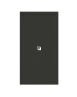

✅ Imagen descargada correctamente desde https://media.adeo.com/media/qsi8uetrzxi1rpqadpdwfk7t3hxuee5jn54fmie con tipo MIME image/jpeg


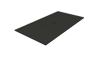

✅ Imagen descargada correctamente desde https://media.adeo.com/media/qsi8uetrzxi1f9fe9pznk35zn84wzotpswydwbe con tipo MIME image/jpeg
✅ IMAGEN SELECCIONADA: 2/2
🎯 ¿Puede añadir cotas 3D?: SÍ
🔍 Confianza: 1.0
⭐ Puntuación de calidad: 10/10

📐 Dimensiones detectadas como visibles:
   • Longitud (lado largo): ✓
   • Anchura (lado corto): ✓
   • Grosor/Altura (espesor): ✓


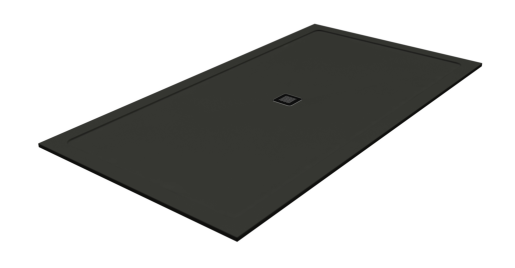

✅ Imagen selecionada para crear cotas desde https://media.adeo.com/media/qsi8uetrzxi1f9fe9pznk35zn84wzotpswydwbe
Image saved at: imagenes_dameo_cotas/mod_Plato_de_ducha/70842912.png

📤 Subiendo imagen a Google Drive...
✅ Carpeta 'Pruebas_cotas' encontrada: 1ExFcpw8ztACfMtFDhZRbwAAhD0s-faNc
   📂 En unidad compartida: 0AD4cVfPueYs1Uk9PVA
   🔍 Buscando subcarpeta 'platos_ducha'...
   ✅ Subcarpeta encontrada: 11yriUh9OZJFI23DbeVfo-WR4dCKJctIN
   ✅ Imagen '70842912.png' subida correctamente
      📎 ID: 1UixhR9wd0FxYxpnp8Rf3aokpw9pnTmLi
      🔗 Ver: https://drive.google.com/file/d/1UixhR9wd0FxYxpnp8Rf3aokpw9pnTmLi/view?usp=drivesdk


In [ ]:
selected_image = None

if images.empty:
    print(f"⚠️ No se encontraron imágenes para la referencia {reference}")
else:
    images_url = images['mediaLinkUrl'].tolist()
    image_parts = []
    images_bytes = []
    for idx, image_url in enumerate(images_url): 
        image_bytes, mime_type = download_image_from_url(image_url)
        
        if image_bytes:
            image = Image.open(BytesIO(image_bytes))
            images_bytes.append(image)
            # Display the image
            plt.figure(figsize=(1, 1))
            plt.imshow(image)
            plt.axis('off') # Hide the X and Y axes
            plt.show()
            
            # Agregar la imagen con su índice
            image_parts.append(Part.from_text(text=f"\n--- IMAGE {idx + 1} ---"))
            image_parts.append(Part.from_bytes(data=image_bytes, mime_type=mime_type))
            
            print(f"✅ Imagen descargada correctamente desde {image_url} con tipo MIME {mime_type}")

        else:
            print(f"⚠️ No se pudo descargar la imagen desde {image_url}")

    # Seleccionar la mejor imagen usando la función definida
    image_selection_result = get_better_image_to_add_pattern(image_parts, number_dimensions)
    selected_index = image_selection_result['selected_index']
    selected_image = images_bytes[selected_index]
    
    plt.imshow(selected_image)
    plt.axis('off') # Hide the X and Y axes
    plt.show()
    print(f"✅ Imagen selecionada para crear cotas desde {images_url[selected_index]}")

    # Guardo la imagen en local
    # Define your path and filename
    folder_path = Path(FOLDER_IMAGES) / f"mod_{model_name.replace(' ', '_')}"
    file_path = folder_path / f"{reference}.png"
    # Create the directory (parents=True creates all missing folders in the path)
    folder_path.mkdir(parents=True, exist_ok=True)
    selected_image.save(file_path)
    print(f"Image saved at: {file_path}")

    # Save image in drive 
    if selected_image is not None:
        print(f"\n📤 Subiendo imagen a Google Drive...")
        
        parent_folder_id = get_drive_folder_id(DRIVE_FOLDER_NAME)

        if parent_folder_id:
            subfolder_id = get_or_create_drive_subfolder(
                f"platos_ducha", 
                parent_folder_id
            )
            
            try:
                drive_file = upload_image_to_drive_from_memory(
                    image=selected_image,
                    file_name=f"{reference}.png",
                    folder_id=subfolder_id
                )
            except Exception as e:
                print(f"❌ Error al subir imagen a Drive: {e}")
        else:
            print(f"❌ No se pudo encontrar la carpeta '{DRIVE_FOLDER_NAME}' en Google Drive")
    else:
        print("⚠️ No hay imagen seleccionada para subir a Drive")

## Generar pictograma


📐 Generando pictograma lineal a partir de la imagen seleccionada
Picto generado correctamente
✅ Pictograma extraída correctamente (parte 0)


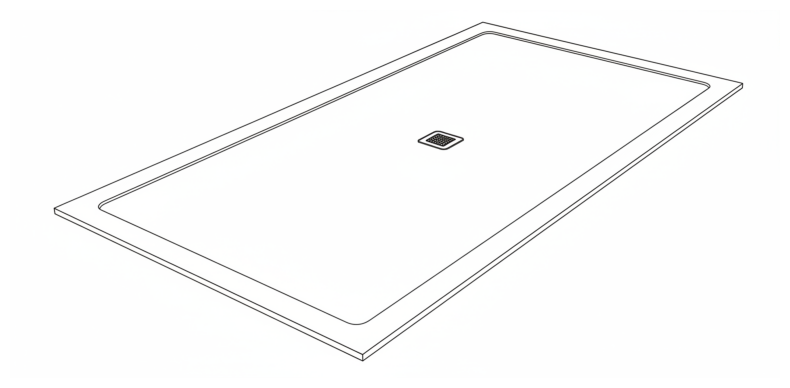

💾 Guardado en: imagenes_dameo_cotas/mod_Plato_de_ducha/70842912-pictogram.png
   ✅ Imagen '70842912-pictogram.png' subida correctamente
      📎 ID: 14n4thzoEWKC7kO4gcZpf5xc6DcvlcngV
      🔗 Ver: https://drive.google.com/file/d/14n4thzoEWKC7kO4gcZpf5xc6DcvlcngV/view?usp=drivesdk


In [135]:
# Crear pictograma a partir de la imagen seleccionada
print(f"\n📐 Generando pictograma lineal a partir de la imagen seleccionada")
pictogram = get_pictogram_from_image(selected_image)

# Extraer imagen de forma segura
pictogram_image = extract_image_from_response(pictogram, "pictograma")

if pictogram_image:
    # Mostrar
    plt.figure(figsize=(8, 8))
    plt.imshow(pictogram_image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Guardar localmente
    folder_path = Path(FOLDER_IMAGES) / f"mod_{model_name.replace(' ', '_')}"
    folder_path.mkdir(parents=True, exist_ok=True)
    file_path = folder_path / f"{reference}-pictogram.png"
    pictogram_image.save(file_path, quality=95, optimize=True)
    print(f"💾 Guardado en: {file_path}")
    
    # Guardar en Drive
    if subfolder_id:
        try:
            drive_file = upload_image_to_drive_from_memory(
                image=pictogram_image,
                file_name=f"{reference}-pictogram.png",
                folder_id=subfolder_id
            )
        except Exception as e:
            print(f"⚠️ No se pudo subir a Drive: {e}")
else:
    print("⚠️ No se pudo generar el pictograma. Verifica la respuesta de la API.")

## Añadir cotas segun las dimensios obtenidas

In [ ]:
image_selection_result

<module 'unittest.result' from '/home/diego/.pyenv/versions/3.11.14/lib/python3.11/unittest/result.py'>

In [ ]:
# Obtener las dimensiones visibles del resultado de selección de imagen
if image_selection_result.get('can_add_3d_dimensions'):
   visible_dims ={'length': True, 'width': True, 'thickness': True}
else:
    visible_dims = {'length': True, 'width': True, 'thickness': False}

print(f"\n📐 Dimensiones detectadas como visibles:")
print(f"   • Longitud: {'✓' if visible_dims.get('length') else '✗'}")
print(f"   • Anchura: {'✓' if visible_dims.get('width') else '✗'}")
print(f"   • Grosor: {'✓' if visible_dims.get('thickness') else '✗'}")

# Generar imagen con cotas usando solo las dimensiones visibles
response = get_dimensions_added_from_pictogram(
    dimensiones=dimensiones,
    image=pictogram_image,
    visible_dimensions=visible_dims
)

if response:
    print(f"✅ Imagen con cotas referencia {reference}")
else:
    print("⚠️ No se pudo generar la imagen con cotas")
    
# Extraer la imagen de la respuesta
if response and response.candidates:
    # Obtener la primera parte de la respuesta que contiene la imagen
    for part in response.candidates[0].content.parts:
        if part.inline_data:
            # Convertir los bytes de la imagen a PIL Image
            image_data = part.inline_data.data
            generated_image = Image.open(BytesIO(image_data))
            
            # Mostrar la imagen
            plt.figure(figsize=(5, 5))
            plt.imshow(generated_image)
            plt.axis('off') # Hide the X and Y axes
            plt.show()
            folder_path = Path(FOLDER_IMAGES) / f"mod_{model_name.replace(' ', '_')}"
            file_path = folder_path / f"{reference}-pat-01.png"
            # Guardar la imagen
            generated_image.save(file_path)
            # Guardar drive 
            drive_file = upload_image_to_drive_from_memory(
                image=generated_image,
                file_name=f"{reference}-pat-ia-01.png",
                folder_id=subfolder_id
            )

AttributeError: module 'unittest.result' has no attribute 'get'